# Dog and cat classification (🐱 or 🐕?)

## Import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import ModelCheckpoint

import pathlib

import zipfile

In [ ]:
path_to_zip_file = "/work/archive.zip"
directory_to_extract_to = "/work/dataset"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

## (Small) Data analysis

In [3]:
p_train = pathlib.Path('/work/dataset/training_set/training_set')

In [35]:
image_count_jpg = len(list(p_train.glob('cats/*.jpg')))
print("Cat images : {:}".format(image_count_jpg))

Cat images : 4000


In [36]:
image_count_jpg = len(list(p_train.glob('dogs/*.jpg')))
print("Dog images : {:}".format(image_count_jpg))

Dog images : 4005


Class are balanced !

## Model

### Initialization

In [4]:
batch_size = 32
img_height = 180
img_width = 180
channel = 3

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  p_train,
  validation_split=0.2,
  subset="training",
  color_mode="rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  p_train,
  validation_split=0.2,
  subset="validation",
  color_mode="rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [19]:
p_test = pathlib.Path('/work/dataset/test_set/test_set')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    p_test,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode="rgb"
)

Found 2023 files belonging to 2 classes.


['cats', 'dogs']


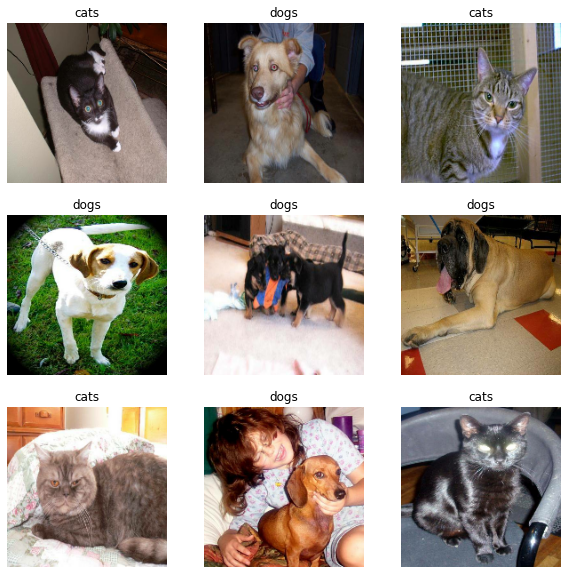

In [8]:
class_names = train_ds.class_names
print(class_names)

#show some dataset images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  channel)),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10),
  ]
)

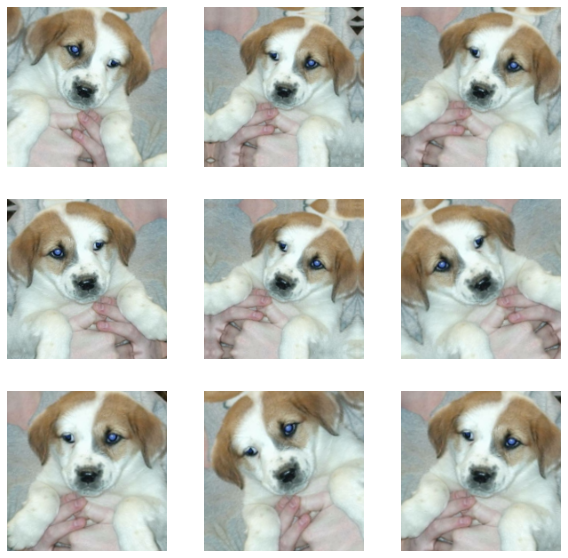

In [10]:
#show data augmentation of single image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
#be sure that input and label are compatible
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
#buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE
#overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
model = Sequential([
    # Data augmentation de solve overfitting problems
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, channel)),

    # Convolutional layer and maxpool layer 1
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional layer and maxpool layer 2
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional layer and maxpool layer 3
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Dropout to solve overfitting problems by setting input units to 0 with a frequency of 0.2 
    layers.Dropout(0.2),

    # Convert multiple dimension to single array
    layers.Flatten(),

    # Hidden layer of 128 neurons
    layers.Dense(128, activation='relu'),

    # Single output neuron
    layers.Dense(1,activation='sigmoid')
])

In [15]:
#after benchmark study, sgd optimizer looks very promising
#binary_crossentropy loss is good option for binary classification 
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [16]:
#callback to save best model during training
filepath_save_model="/work/models/weights-improvement-v2-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath_save_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### Training

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list
)

Epoch 1/50
201/201 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5339
Epoch 1: val_accuracy improved from -inf to 0.51280, saving model to /work/models/weights-improvement-v2-01-0.51.hdf5
201/201 [==============================] - 386s 2s/step - loss: 0.6902 - accuracy: 0.5339 - val_loss: 0.6951 - val_accuracy: 0.5128
Epoch 2/50
201/201 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5575
Epoch 2: val_accuracy improved from 0.51280 to 0.58151, saving model to /work/models/weights-improvement-v2-02-0.58.hdf5
201/201 [==============================] - 366s 2s/step - loss: 0.6826 - accuracy: 0.5575 - val_loss: 0.6749 - val_accuracy: 0.5815
Epoch 3/50
201/201 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.5803
Epoch 3: val_accuracy improved from 0.58151 to 0.59338, saving model to /work/models/weights-improvement-v2-03-0.59.hdf5
201/201 [==============================] - 376s 2s/step - loss: 0.6748 - accuracy: 0.580

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

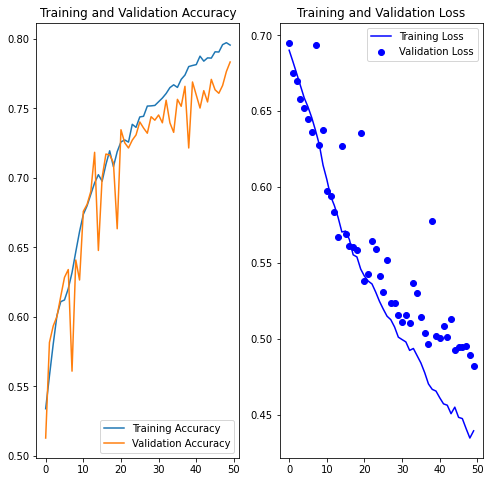

In [ ]:
epochs_range = range(epochs)

#show training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#show training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color="blue")
plt.scatter(epochs_range, val_loss, label='Validation Loss',color="blue",marker = 'o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test

In [37]:
#load best model
model = keras.models.load_model('/work/models/weights-improvement-v2-50-0.78.hdf5')

In [38]:
results = model.evaluate(test_ds)
#0.77 accuracy
#0.47 loss

64/64 [==============================] - 40s 601ms/step - loss: 0.4734 - accuracy: 0.7652


In [39]:
#test on 1000 images per class !
predictions = model.predict(test_ds)

64/64 [==============================] - 40s 606ms/step


In [40]:
#get 3 good and bad predictions for cat images
test_cat_images = list(p_test.glob("cats/*.jpg"))
pathCatOk = []
scorePredCatOk = []
pathCatNotOk = []
scorePredCatNotOk = []

for p in test_cat_images:
    img = keras.preprocessing.image.load_img(
        str(p.resolve()), color_mode="rgb", target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    prediction = model.predict(img_array)
    score = int(np.round(prediction))
    if (score==0 and len(pathCatOk)<3):
        pathCatOk.append(str(p.resolve()))
        scorePredCatOk.append(prediction)
    elif (score==1 and len(pathCatNotOk)<3):
        pathCatNotOk.append(str(p.resolve()))
        scorePredCatNotOk.append(prediction)

    if (len(scorePredCatOk)==3 and len(scorePredCatNotOk)==3):
        break

1/1 [==============================] - 0s 45ms/step


In [41]:
#get 3 good and bad predictions for dog images
test_dog_images = list(p_test.glob("dogs/*.jpg"))
test_dog_images

pathDogOk = []
scorePredDogOk = []
pathDogNotOk = []
scorePredDogNotOk = []

for p in test_dog_images:
    img = keras.preprocessing.image.load_img(
        str(p.resolve()), color_mode="rgb", target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    prediction = model.predict(img_array)
    score = int(np.round(prediction))
    print(score)
    if (score==1 and len(pathDogOk)<3):
        pathDogOk.append(str(p.resolve()))
        scorePredDogOk.append(prediction)
    elif (score==0 and len(pathDogNotOk)<3):
        pathDogNotOk.append(str(p.resolve()))
        scorePredDogNotOk.append(prediction)
    
    print("{:} / {:}".format(len(pathDogNotOk),len(pathDogOk)))
    if (len(scorePredDogOk)==3 and len(scorePredDogNotOk)==3):
        break


1/1 [==============================] - 0s 90ms/step
1
0 / 1
1/1 [==============================] - 0s 45ms/step
1
0 / 2
1/1 [==============================] - 0s 93ms/step
0
1 / 2
1/1 [==============================] - 0s 44ms/step
1
1 / 3
1/1 [==============================] - 0s 50ms/step
1
1 / 3
1/1 [==============================] - 0s 53ms/step
1
1 / 3
1/1 [==============================] - 0s 46ms/step
1
1 / 3
1/1 [==============================] - 0s 77ms/step
0
2 / 3
1/1 [==============================] - 0s 130ms/step
1
2 / 3
1/1 [==============================] - 0s 74ms/step
0
3 / 3


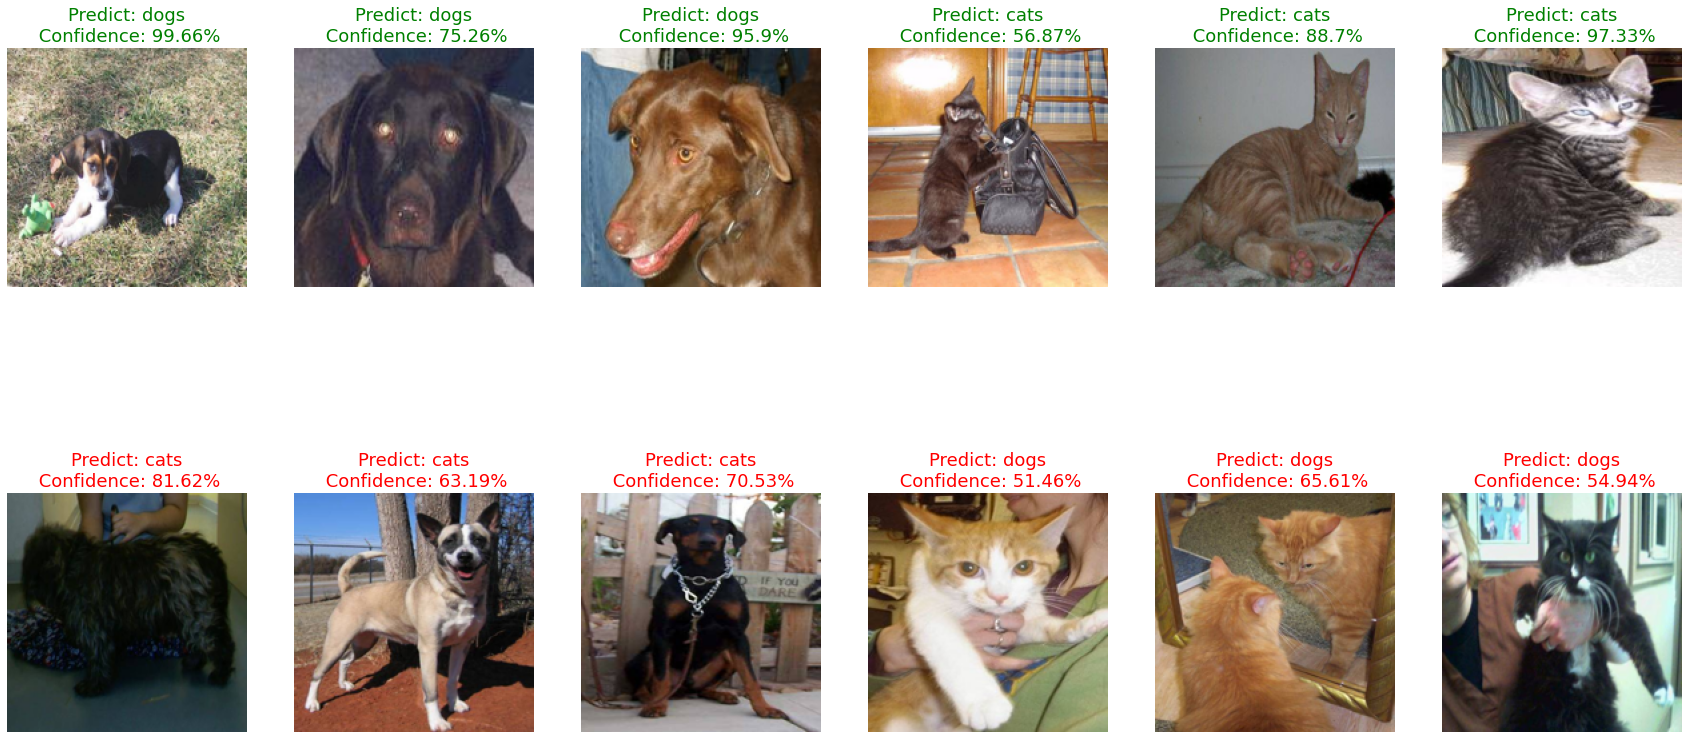

In [42]:
#show good and bad predictions
from PIL import Image

pathOk = pathDogOk + pathCatOk
predOk = scorePredDogOk + scorePredCatOk
pathNotOk = pathDogNotOk + pathCatNotOk
predNotOk = scorePredDogNotOk + scorePredCatNotOk


path = pathOk + pathNotOk 
pred = predOk + predNotOk
color = ["green" if val < 6  else "red" for val in range(12)]
fig , ax = plt.subplots(2, 6, figsize=(30, 15))

for i, axis in enumerate(ax.flat):
    image = Image.open(path[i]) 
    image = image.resize((img_width, img_height))
    axis.imshow(image)
    pred_prob = round(pred[i][0][0]*100,2)
    pred_class = class_names[int(np.round(pred[i]))]
    #if cat
    if int(np.round(pred[i])) == 0:
        pred_prob = 100-pred_prob

    axis.set_axis_off()
    axis.set_title(f'Predict: {pred_class}\n Confidence: {pred_prob:}%', fontsize=18, color = color[i])
    


## Are my animals recognizable thanks to my model?

### First example

1/1 [==============================] - 0s 50ms/step
It's a cat !


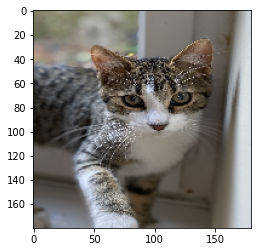

In [43]:
p_cat = pathlib.Path('/work/my_cat.jpg')

img = keras.preprocessing.image.load_img(
    p_cat, color_mode="rgb", target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

plt.imshow(img)

predictions = model.predict(img_array)
if predictions[0][0]<0.5:
    print("It's a cat !")
else:
    print("It's a dog")


### Second example

1/1 [==============================] - 0s 77ms/step
It's a dog


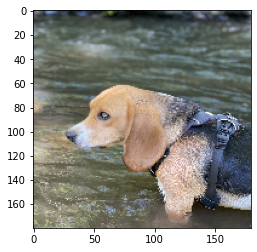

In [44]:
p_cat = pathlib.Path('/work/my_dog.jpg')

img = keras.preprocessing.image.load_img(
    p_cat, color_mode="rgb", target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

plt.imshow(img)

predictions = model.predict(img_array)
if predictions[0][0]<0.5:
    print("It's a cat !")
else:
    print("It's a dog")


## Some areas for improvement

• Use transfer learning but for this exercise it would have been cheating so I didn't use it

• Optimize the prediction threshold after displaying the roc curve

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a8539e-686c-426b-a381-2b145890cf6a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>